(solph-minimal-load)=

# oemof-solph model with minimal load

This is a transition section to get people from the other chapter and bring them to part load modeling

- partload in general:
  - difficulties in finding part load efficiency data
  - BUT: we can model it in solph, and here is how

Therefore 

- use simplified version of the TESPy model as input data
- show how to model part load in solph
  - constant efficiency, no offset
  - prepare transfer to offset transformer
- we can compare the results between the partload model and the full linear model

However

- We know how to have minimal load in solph, but what about partload COP?
  - tespy section with partload performance


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utilities import load_temperature_data

input_data = load_temperature_data().head(24*3)


# A crude demand model should be enough for us. Let the demand be 500 W per K below 15 °C.
input_data["Heat load (kW)"] = (0.5 * (15 - 0.1*input_data["Ambient temperature (d°C)"])).clip(lower=0)


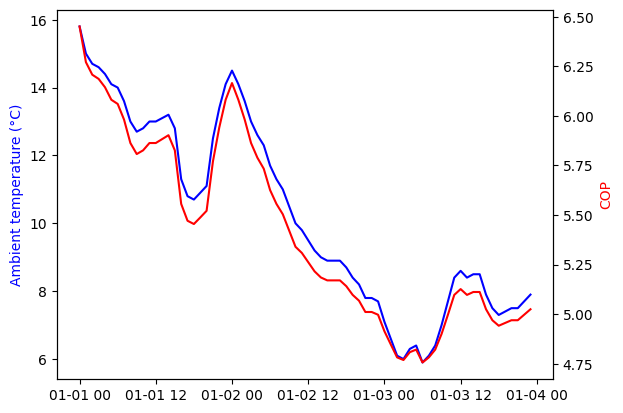

In [2]:
def load_tespy_cop():
    df = pd.read_csv("COP-T-tespy.csv", index_col=[0])

    # hack to work with floats as index
    df2 = df.reindex(np.arange(-100, 311, 1)/10)

    df2["COP"] = pd.Series.interpolate(df2["COP"])

    df2.index = 10 * df2.index

    return df2

tespy_cop = load_tespy_cop()

input_data["simple TESPy COP"] = input_data["Ambient temperature (d°C)"].map(tespy_cop["COP"])

plt.plot(input_data["Ambient temperature (d°C)"]/10, "b-")
plt.ylabel("Ambient temperature (°C)").set_color("blue")

plt.twinx()

plt.plot(input_data["simple TESPy COP"], "r-")
plt.ylabel("COP").set_color("red")

plt.show()



In [3]:
hp_thermal_power = 9.1  # kW
cop = input_data["simple TESPy COP"][:-1]
demand = input_data["Heat load (kW)"][:-1]

With respect to the previous version (solph-with-tespy), a minimal load of 50 % is added.

In [4]:
import oemof.solph as solph

es = solph.EnergySystem(timeindex=input_data.index, infer_last_interval=False)

b_electricity = solph.Bus(label="electricity")
b_heat_35C = solph.Bus(label="heat 35C")
es.add(b_electricity, b_heat_35C)

electricity_grid = solph.components.Source(
    label="electricity grid",
    outputs={b_electricity: solph.Flow(variable_costs=0.4)},  # €/kWh
)

heat_demand = solph.components.Sink(
    label="heat demand",
    inputs={b_heat_35C: solph.Flow(nominal_value=1, fix=demand)},  # kW
)
es.add(electricity_grid, heat_demand)


heat_pump = solph.components.Transformer(
    label="heat pump",
    inputs={b_electricity: solph.Flow()},
    outputs={
        b_heat_35C: solph.Flow(
            nominal_value=hp_thermal_power,
            nonconvex=solph.NonConvex(),
            min=0.5,
        )
    },
    conversion_factors={
        b_electricity: 1 / cop,
        b_heat_35C: 1,
    },
)

es.add(heat_pump)

es.add(solph.components.Transformer(
    label="heating rod",
    inputs={b_electricity: solph.Flow()},
    outputs={b_heat_35C: solph.Flow()},
))

thermal_storage = solph.components.GenericStorage(
    label='thermal_storage',
    inputs={b_heat_35C: solph.Flow()},
    outputs={b_heat_35C: solph.Flow()},
    loss_rate=0.02,
    nominal_storage_capacity=8.7,  # Assume 5 k of spread and 1.5 m³ volume 
)

es.add(thermal_storage)

model = solph.Model(energysystem=es)

model.solve()

results = solph.processing.results(model)



Electricity demand: 33.2 kWh


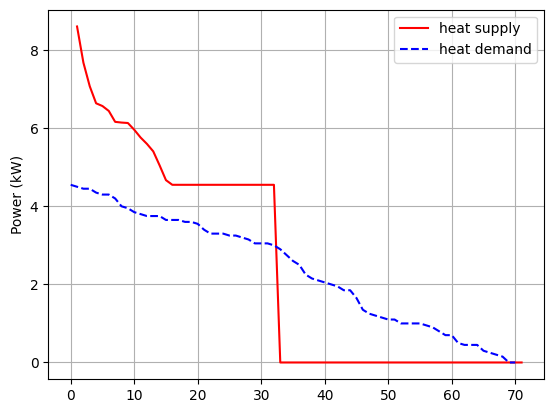

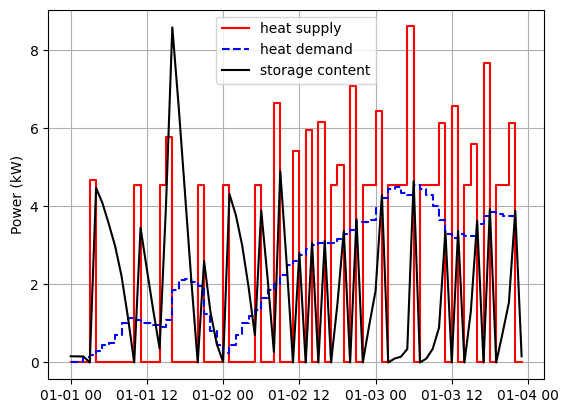

In [5]:
heat_supply = results[(heat_pump, b_heat_35C)]["sequences"]["flow"]
storage_content = results[(thermal_storage, None)]["sequences"]["storage_content"]

plt.plot(np.sort(heat_supply)[::-1], "r-", label="heat supply")
plt.plot(np.sort(demand)[::-1], "b--", label="heat demand")
plt.ylabel("Power (kW)")
plt.grid()
plt.legend()

plt.figure()
plt.plot(heat_supply, "r-", label="heat supply", drawstyle="steps-post")
plt.plot(demand, "b--", label="heat demand", drawstyle="steps-post")
plt.plot(storage_content, "k-", label="storage content")
plt.ylabel("Power (kW) or Energy (kWh)")
plt.grid()
plt.legend()

electricity_consumption = float(results[(electricity_grid, b_electricity)]["sequences"].sum())
print(f"Electricity demand: {electricity_consumption:.1f} kWh")
